In [1]:
import os
import glob
from PIL import Image

import pickle
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision as tv
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/christoph/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
ROOT_DIR = "[PATH TO GTSRB]/GTSRB/"
IMG_SIZE = 64
BATCH_SIZE = 128
LATENT_DIMS = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_csv = pd.read_csv(ROOT_DIR + "Train.csv")
valid_csv = pd.read_csv(ROOT_DIR + "Test.csv")

train_files = train_csv[["Path", "ClassId"]]
valid_files = valid_csv[["Path", "ClassId"]]

In [4]:
tfms = tv.transforms.Compose([tv.transforms.Resize((IMG_SIZE, IMG_SIZE)), tv.transforms.ToTensor()])

In [5]:
filenames = [os.path.join(dirpath,filename) for dirpath, _, filenames in os.walk(ROOT_DIR + "Train/") for filename in filenames if filename.endswith('.png')]

In [9]:
file_arr = []
for i in tqdm(range(len(filenames))):
    image = Image.open(filenames[i])
    tens = tfms(image)
    conv_filename = filenames[i].split("GTSRB/")[-1]
    class_id = int(train_files[train_files["Path"] == conv_filename]["ClassId"].astype(int))
    tens_id_arr = [tens, class_id]
    file_arr.append(tens_id_arr)
    
random.shuffle(file_arr)

100%|██████████| 39209/39209 [01:42<00:00, 384.20it/s]


In [10]:
train_files = file_arr[:-800]
valid_files = file_arr[-800:]

In [11]:
class TSDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x = self.files[idx][0]
        label = self.files[idx][1]
            
        return x, label

In [12]:
training_data = TSDataset(train_files, tfms)
valid_data = TSDataset(valid_files, tfms) 

In [13]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

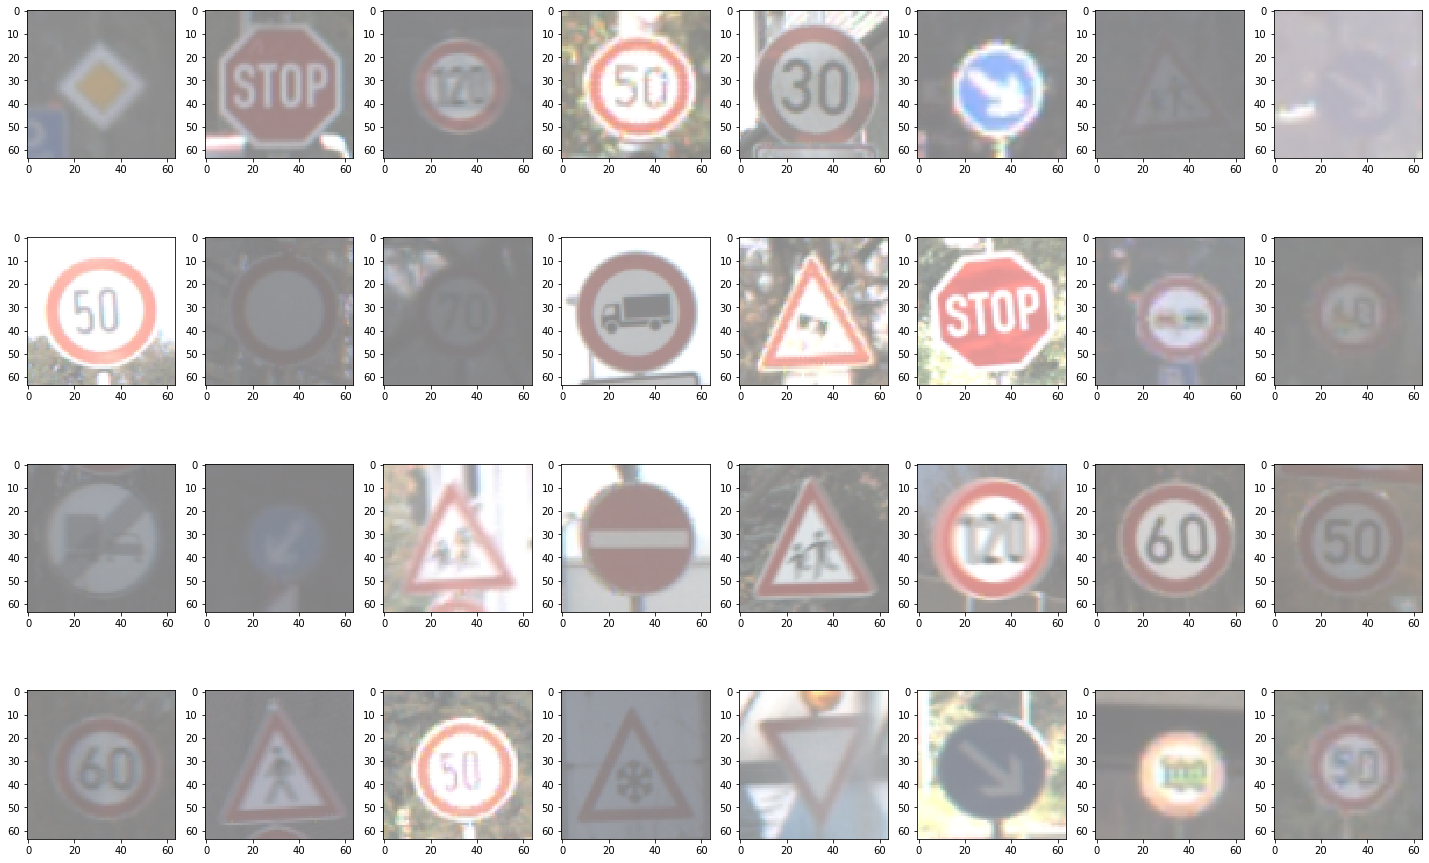

In [14]:
data, labels = next(iter(valid_dataloader))
n_cols = 8
n_rows = 4

fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(data):
    
    if (n_cols*n_rows) >= (i + 1):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        img = img.numpy().transpose(1, 2, 0)
        plt.imshow((img+1.)/2.)

In [15]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [22]:
class CVAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.signclass_embedding = nn.Embedding(43, 20)
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim + 20)
        self.z2h = nn.Linear(z_dim + 20, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).to(DEVICE)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h, label):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        
        signclass = self.signclass_embedding(label.long())
        signclass = signclass.squeeze(dim=1)
        mu = torch.cat([mu, signclass], dim=1)

        z = self.reparameterize(mu, logvar)
        
        return z, mu, logvar
        
    def encode(self, x, label):
        return self.bottleneck(self.encoder(x), label)[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x, label):
        h = self.encoder(x)
        z_small, mu, logvar = self.bottleneck(h, label)
        z = self.z2h(z_small)
        return self.decoder(z), mu, logvar, z_small, z

In [23]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, IMG_SIZE*IMG_SIZE*3),
                                 x.view(-1, IMG_SIZE*IMG_SIZE*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [24]:
model = CVAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
def num_params(model):
    return sum(p.numel() for p in model.parameters())

num_params(model)

4390387

In [26]:
def plot_interm_results():
    x, label = next(iter(valid_dataloader))

    if torch.cuda.is_available():
        x, label = x.cuda(), label.type(torch.FloatTensor).unsqueeze(dim=1).cuda()

    imgs, mu, logvar, _, _ = model(x, label)
    imgs = imgs.detach().cpu()          

    n_cols = 8
    n_rows = 4

    fig = plt.figure(figsize=(25, 16))
    for i in range(n_cols*n_rows):

        if (n_cols*n_rows) >= (i + 1):
            ax = fig.add_subplot(n_rows, n_cols, i + 1)
            img = imgs[i]
            img = img.permute(1, 2, 0)
            plt.imshow((img+1.)/2.)

In [2]:
epochs = 900
epoch_train_losses = []
epoch_valid_losses = []

for epoch in tqdm(range(epochs)):
    batch_train_losses = []
    batch_valid_losses = []
    
    for data, label in train_dataloader:

        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, label = data.cuda(), label.type(torch.FloatTensor).unsqueeze(dim=1).cuda()

        recon_batch, mu, logvar, _, _ = model(data, label)  
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())
    epoch_train_losses.append(np.mean(batch_train_losses))
    
    model.eval()  
    for data, label in valid_dataloader:
        if torch.cuda.is_available():
            data, label = data.cuda(), label.type(torch.FloatTensor).unsqueeze(dim=1).cuda()
        
        recon_x, mu, logvar, _, _ = model(data, label)
        loss = vae_loss(recon_x, data, mu, logvar)
        
        batch_valid_losses.append(loss.item())
    epoch_valid_losses.append(np.mean(batch_valid_losses))
    
    
    if epoch % 100 == 0:
        torch.save(model.state_dict(), "ccvae_64_signs_{}.pth".format(epoch))
        
    print(f'Epoch {epoch+1} \t\t Training Loss: {np.mean(epoch_train_losses)} \t\t Validation Loss: {np.mean(epoch_valid_losses)}')
     
    plt.plot(epoch_train_losses, label = "train_loss")
    plt.plot(epoch_valid_losses, label = "valid_loss")

    plot_interm_results()
    plt.show()

  0%|          | 0/900 [00:00<?, ?it/s]


NameError: name 'train_dataloader' is not defined